In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
data = pd.read_excel("IMPORTACION-VOLUMEN-2024-05.xlsx", index_col="Fecha", parse_dates=["Fecha"], date_format="%Y-%m-%d ", skiprows=6, skipfooter=3)

import_data = data[['Gasolina regular', 'Gasolina superior', 'Gas licuado de petróleo']]
import_data

,Gasolina regular,Gasolina superior,Gas licuado de petróleo
Fecha,,,
2001-01-01 00:00:00,177776.50,373963.96,194065.738095
2001-02-01 00:00:00,123115.99,243091.07,170703.380952
2001-03-01 00:00:00,161726.42,312084.38,161837.371429
2001-04-01 00:00:00,127338.74,285054.89,163048.642857
2001-05-01 00:00:00,168730.19,300913.67,171518.861905
...,...,...,...
2024-01-01 00:00:00,914133.32,712333.33,701570.800000
2024-02-01 00:00:00,740662.25,650360.11,916541.700000
2024-03-01 00:00:00,838270.93,620077.74,675157.480000


In [3]:
start_date = '2017-12-01'

import_data['Diesel'] = np.where((data.index <= start_date),
                                    data['Diesel alto azufre'],
                                    data['Diesel bajo azufre'])

import_data['Diesel']

/var/folders/nh/qxcg2qs54dq8v4tnbxqzpm7w0000gn/T/ipykernel_7608/2775745780.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import_data['Diesel'] = np.where((data.index <= start_date),


Fecha
2001-01-01 00:00:00     566101.99
2001-02-01 00:00:00     489525.80
2001-03-01 00:00:00     575559.68
2001-04-01 00:00:00     437745.42
2001-05-01 00:00:00     552609.13
                          ...    
2024-01-01 00:00:00    1409097.15
2024-02-01 00:00:00    1236861.75
2024-03-01 00:00:00    1477038.00
2024-04-01 00:00:00    1294706.12
2024-05-01 00:00:00    1470870.09
Name: Diesel, Length: 281, dtype: float64

In [4]:
inicio = min(import_data.index)
inicio
values = import_data.loc[inicio]
print("Fecha: ", inicio, "Valor: ", values['Gasolina superior'])

Fecha:  2001-01-01 00:00:00 Valor:  373963.96


In [5]:
fin = max(import_data.index)
fin
values = import_data.loc[fin]
print("Fecha: ", fin, "Valor: ", values['Gasolina superior'])

Fecha:  2024-05-01 00:00:00 Valor:  696970.3


In [6]:
infer_frec = pd.infer_freq(import_data['Gasolina superior'].index)
infer_frec

'MS'

In [7]:
# Replace zero values with NaN
import_data = import_data.replace(0, np.nan)

# Drop rows with NaN values (which were originally zero values)
import_data = import_data.dropna()

/var/folders/nh/qxcg2qs54dq8v4tnbxqzpm7w0000gn/T/ipykernel_7608/1110981822.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  import_data_yearly = import_data.resample('Y').sum()


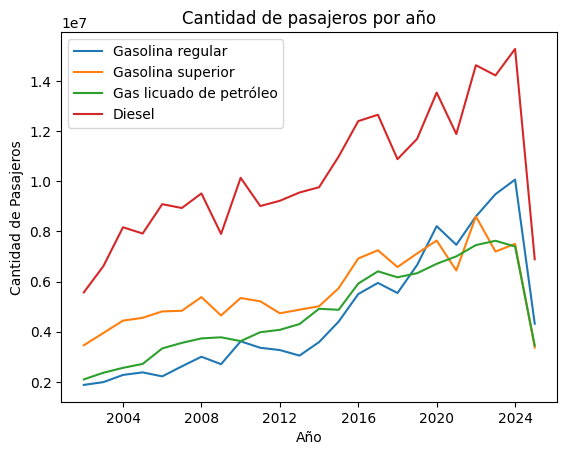

In [8]:
import matplotlib.dates as mdates

# Assuming consume_data is already loaded

# Ensure the index is a DatetimeIndex
if not isinstance(import_data.index, pd.DatetimeIndex):
    import_data.index = pd.to_datetime(import_data.index)

# Group the data by year and sum the values
import_data_yearly = import_data.resample('Y').sum()

# Plot the aggregated data
plt.plot(import_data_yearly)

# Set the title and labels
plt.gca().set(title="Cantidad de pasajeros por año", xlabel="Año", ylabel="Cantidad de Pasajeros")

# Format the x-axis to display only the year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a legend
plt.legend(import_data.columns)

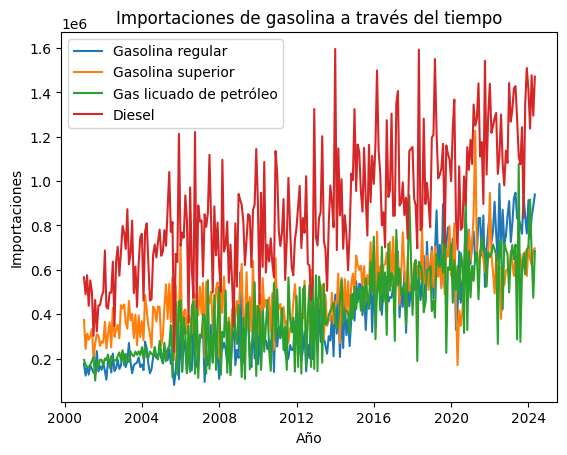

In [9]:
plt.plot(import_data)
plt.gca().set(title="Importaciones de gasolina a través del tiempo", xlabel="Año", ylabel="Importaciones")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend(import_data.columns)
plt.show()

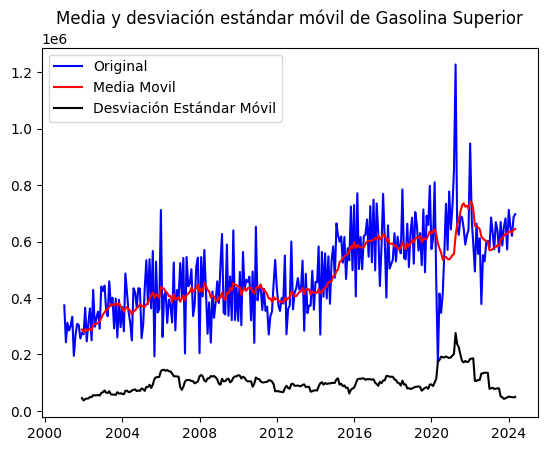

In [10]:
import_data = import_data['Gasolina superior']

# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = import_data.rolling(window=12).mean()
deMovil = import_data.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(import_data, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil de Gasolina Superior')
plt.show(block=False)

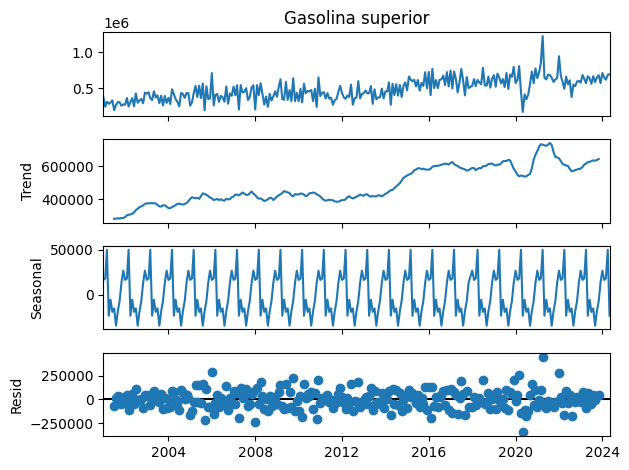

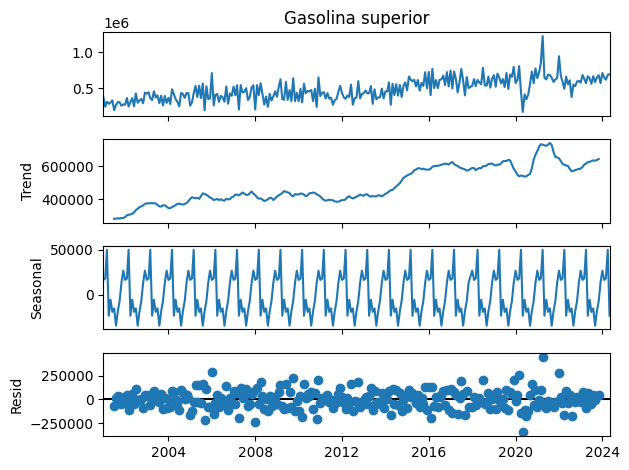

In [11]:
descomposicion = seasonal_decompose(import_data, model='additive', period=12)
descomposicion.plot()

In [12]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(import_data, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -2.923066
p-value                        0.042731
# de retardos usados           3.000000
# de observaciones usadas    276.000000
Critical Value (1%)           -3.454267
Critical Value (5%)           -2.872070
Critical Value (10%)          -2.572381
dtype: float64


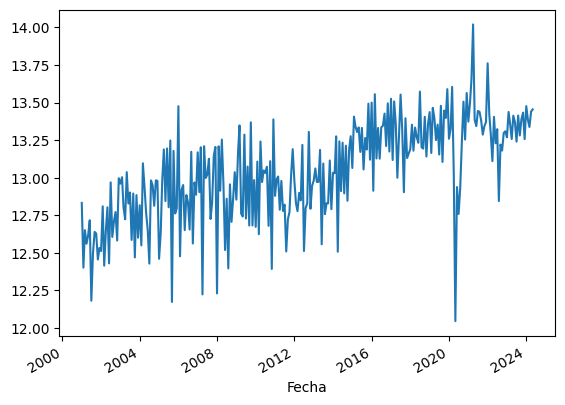

In [13]:
import_data_log = np.log(import_data)
import_data_log.plot()
import_data_log_diff = import_data_log.diff()
import_data_log_diff.dropna(inplace=True)

<Axes: xlabel='Fecha'>

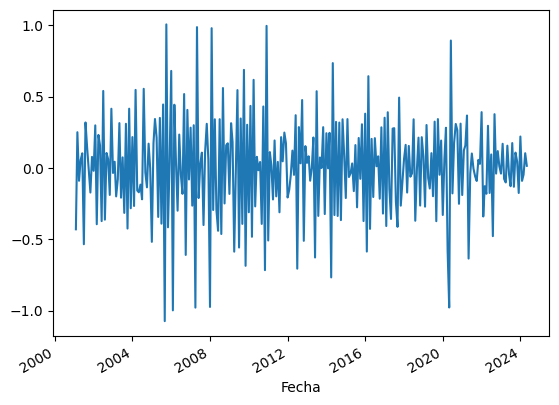

In [14]:
import_data_log_diff.plot()

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 8 retardos')

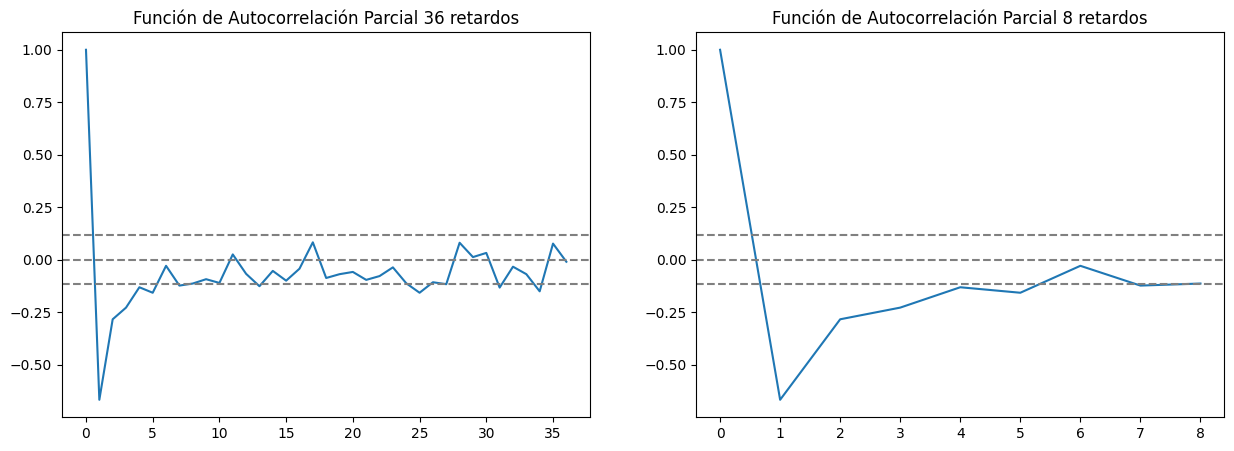

In [15]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.subplot(121)
plt.plot(pacf(import_data_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(import_data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(import_data_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(import_data_log_diff, nlags=8))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(import_data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(import_data_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 8 retardos')

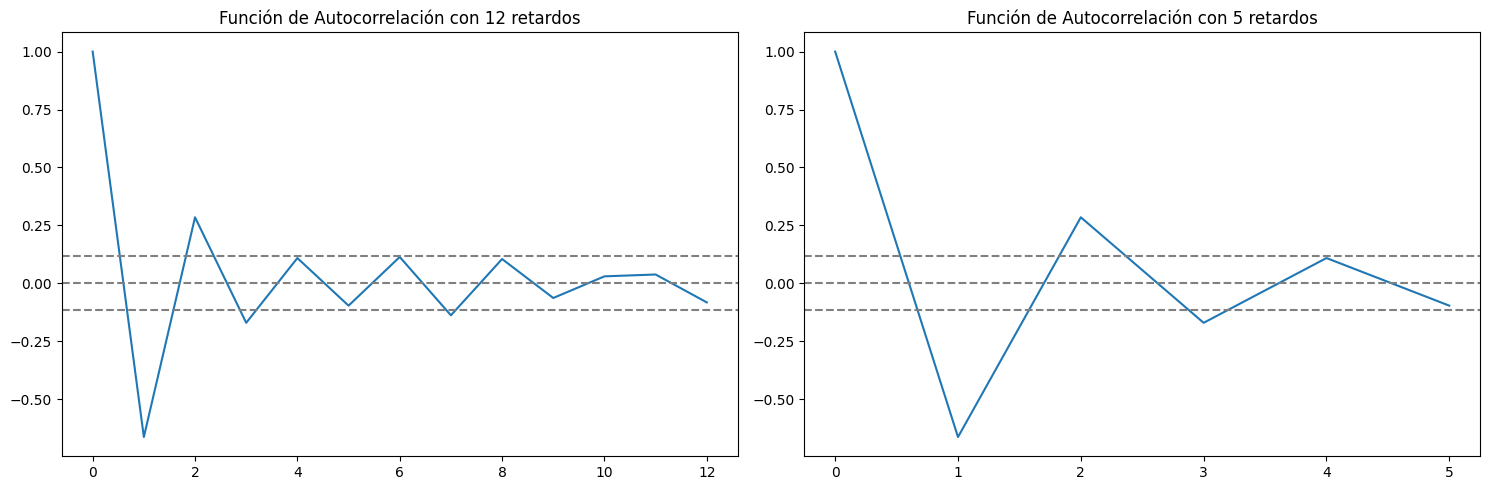

In [16]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(import_data_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(import_data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(import_data_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(import_data_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(import_data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(import_data_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

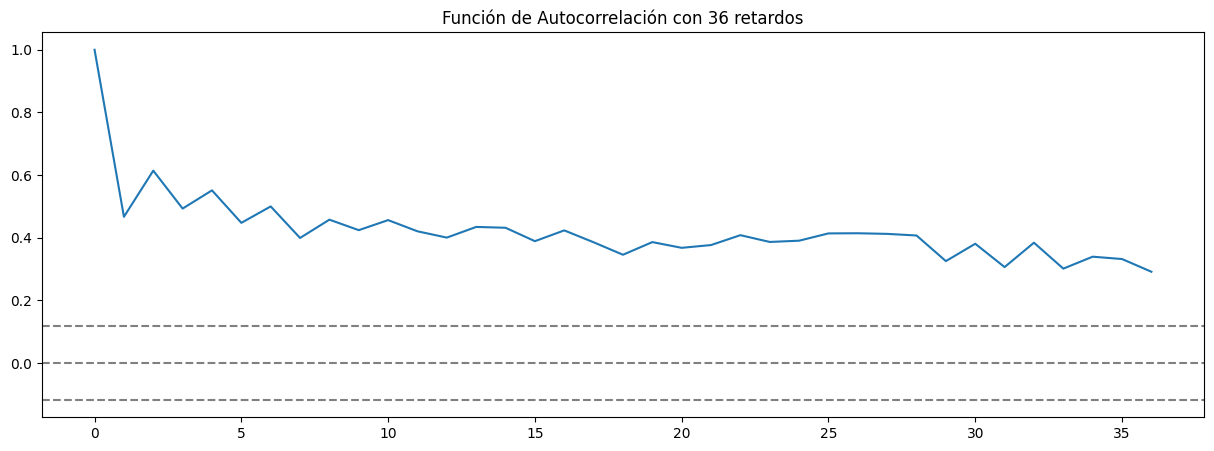

In [17]:
plt.plot(acf(import_data,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(import_data)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(import_data)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [18]:
model111 = ARIMA(import_data_log, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
resultado_m111 = model111.fit()
print(resultado_m111.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2475      0.065     -3.835      0.000      -0.374      -0.121
ma.L1         -0.8042      0.039    -20.474      0.000      -0.881      -0.727
sigma2         0.0564      0.003     18.299      0.000       0.050       0.062


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


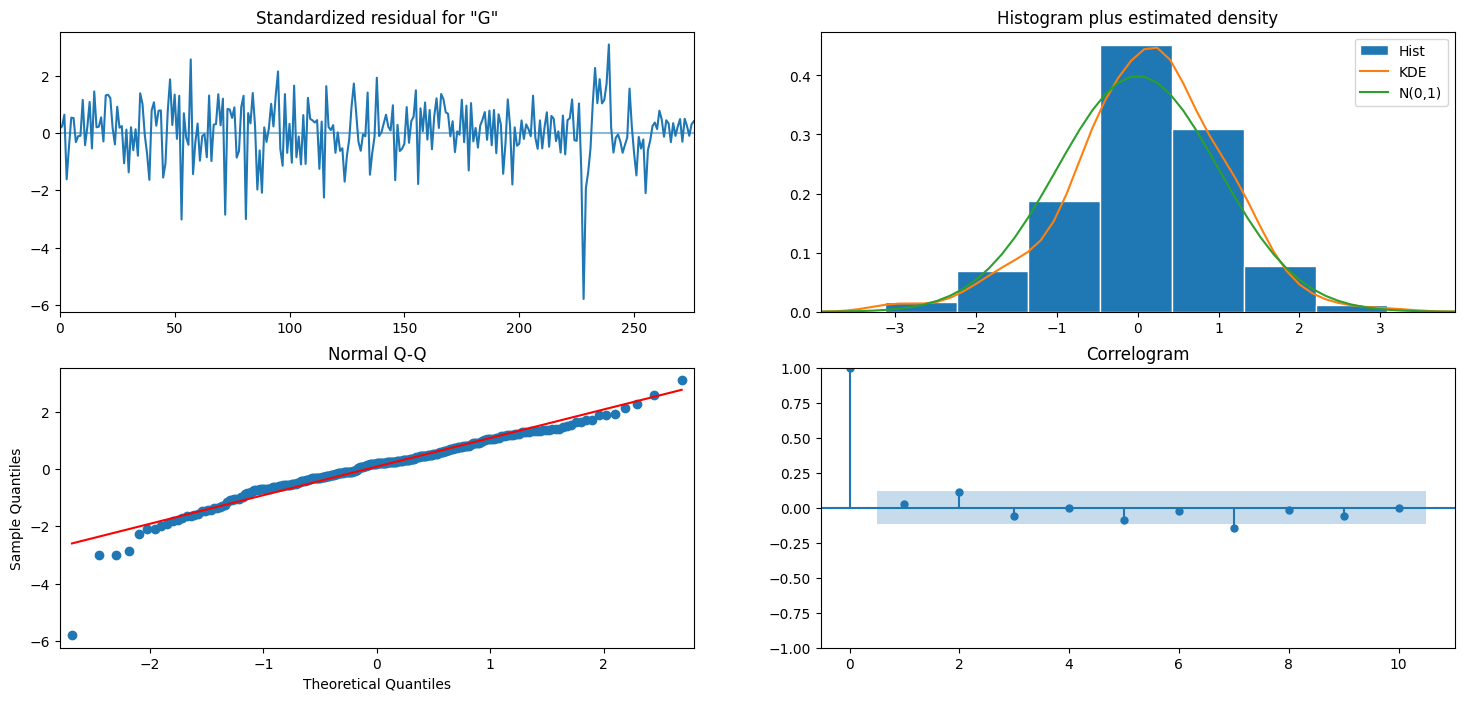

In [19]:
resultado_m111.plot_diagnostics(figsize=(18, 8))
plt.show()

In [20]:
model211 = ARIMA(import_data_log, order=(2, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
resultado_m211 = model211.fit()
print(resultado_m211.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1236      0.068     -1.815      0.070      -0.257       0.010
ar.L2          0.2100      0.074      2.821      0.005       0.064       0.356
ma.L1         -0.9027      0.039    -22.908      0.000      -0.980      -0.826
sigma2         0.0546      0.003     17.898      0.000       0.049       0.061


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


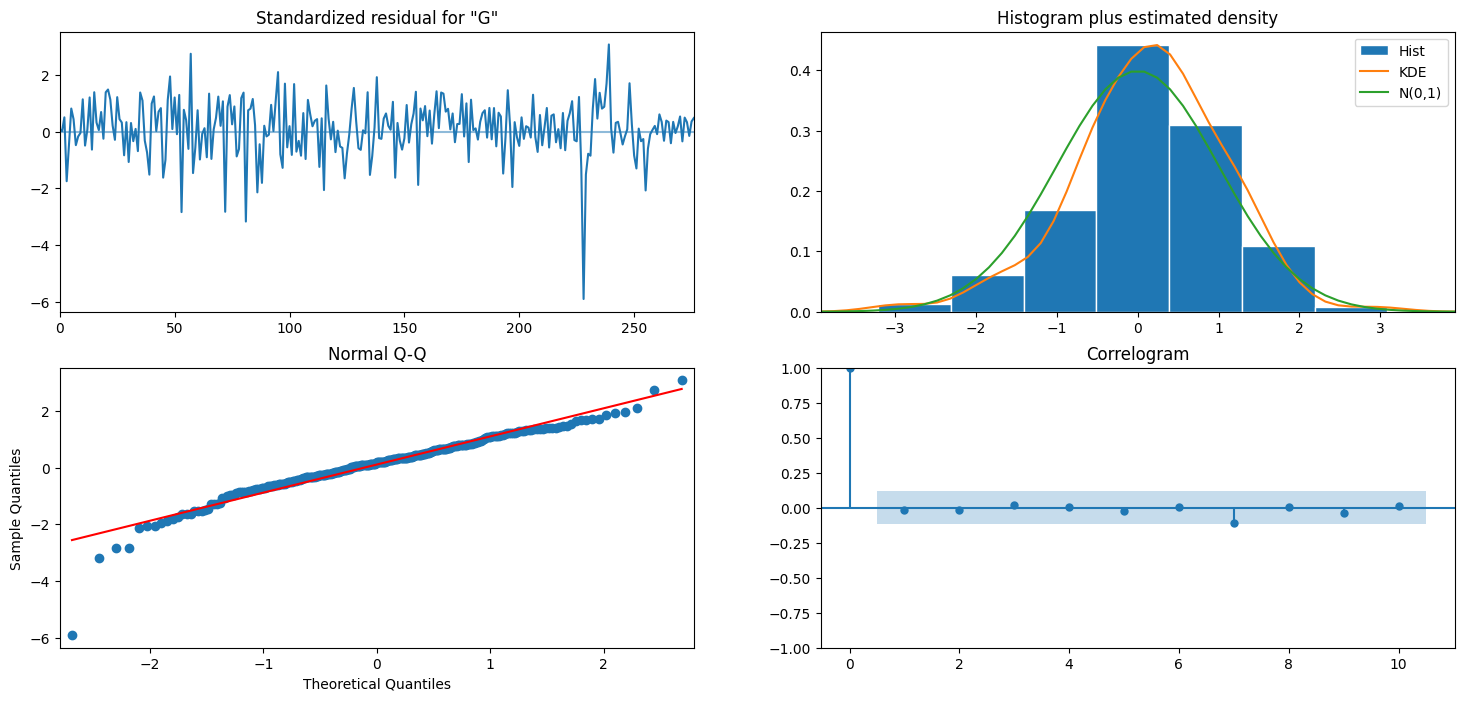

In [21]:
resultado_m211.plot_diagnostics(figsize=(18, 8))
plt.show()

In [ ]:
model212 = ARIMA(import_data_log, order=(2, 1, 2), enforce_stationarity=False, enforce_invertibility=False)
resultado_m212 = model212.fit()
print(resultado_m212.summary().tables[1])

In [22]:
model311 = ARIMA(import_data_log, order=(3, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
resultado_m311 = model311.fit()
print(resultado_m311.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1228      0.068     -1.794      0.073      -0.257       0.011
ar.L2          0.2193      0.079      2.765      0.006       0.064       0.375
ar.L3          0.0238      0.073      0.326      0.744      -0.119       0.167
ma.L1         -0.9084      0.044    -20.867      0.000      -0.994      -0.823
sigma2         0.0547      0.003     17.754      0.000       0.049       0.061


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


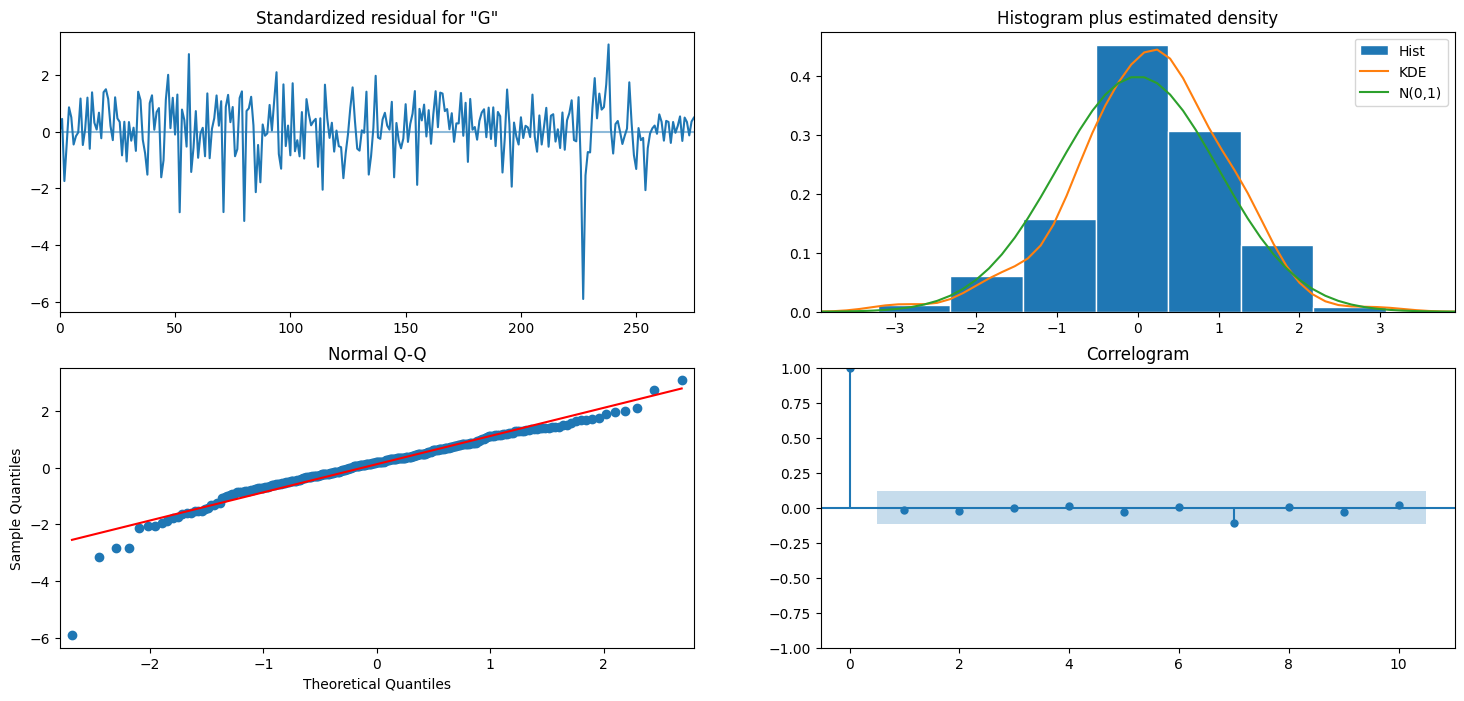

In [23]:
resultado_m311.plot_diagnostics(figsize=(18, 8))
plt.show()

In [24]:
model411 = ARIMA(import_data_log, order=(4, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
resultado_m411 = model411.fit()
print(resultado_m411.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1159      0.069     -1.686      0.092      -0.251       0.019
ar.L2          0.2195      0.079      2.768      0.006       0.064       0.375
ar.L3          0.0352      0.078      0.452      0.651      -0.117       0.188
ar.L4          0.0403      0.062      0.655      0.513      -0.080       0.161
ma.L1         -0.9165      0.045    -20.336      0.000      -1.005      -0.828
sigma2         0.0548      0.003     17.182      0.000       0.049       0.061


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


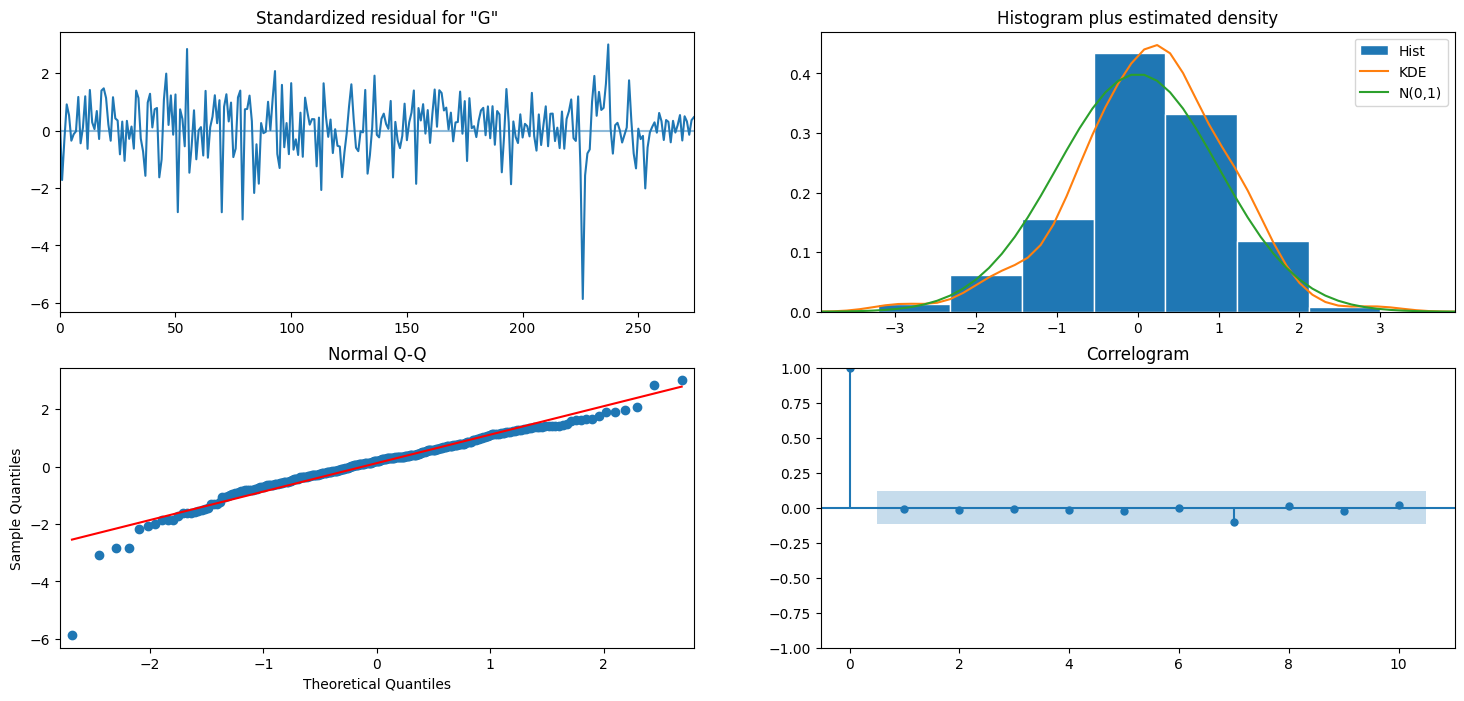

In [25]:
resultado_m411.plot_diagnostics(figsize=(18, 8))
plt.show()

In [26]:
model511 = ARIMA(import_data_log, order=(5, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
resultado_m511 = model511.fit()
print(resultado_m511.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1192      0.071     -1.670      0.095      -0.259       0.021
ar.L2          0.2158      0.080      2.692      0.007       0.059       0.373
ar.L3          0.0367      0.078      0.470      0.638      -0.116       0.190
ar.L4          0.0346      0.064      0.540      0.589      -0.091       0.160
ar.L5         -0.0258      0.060     -0.431      0.666      -0.143       0.092
ma.L1         -0.9121      0.049    -18.479      0.000      -1.009      -0.815
sigma2         0.0550      0.003     17.044      0.000       0.049       0.061


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


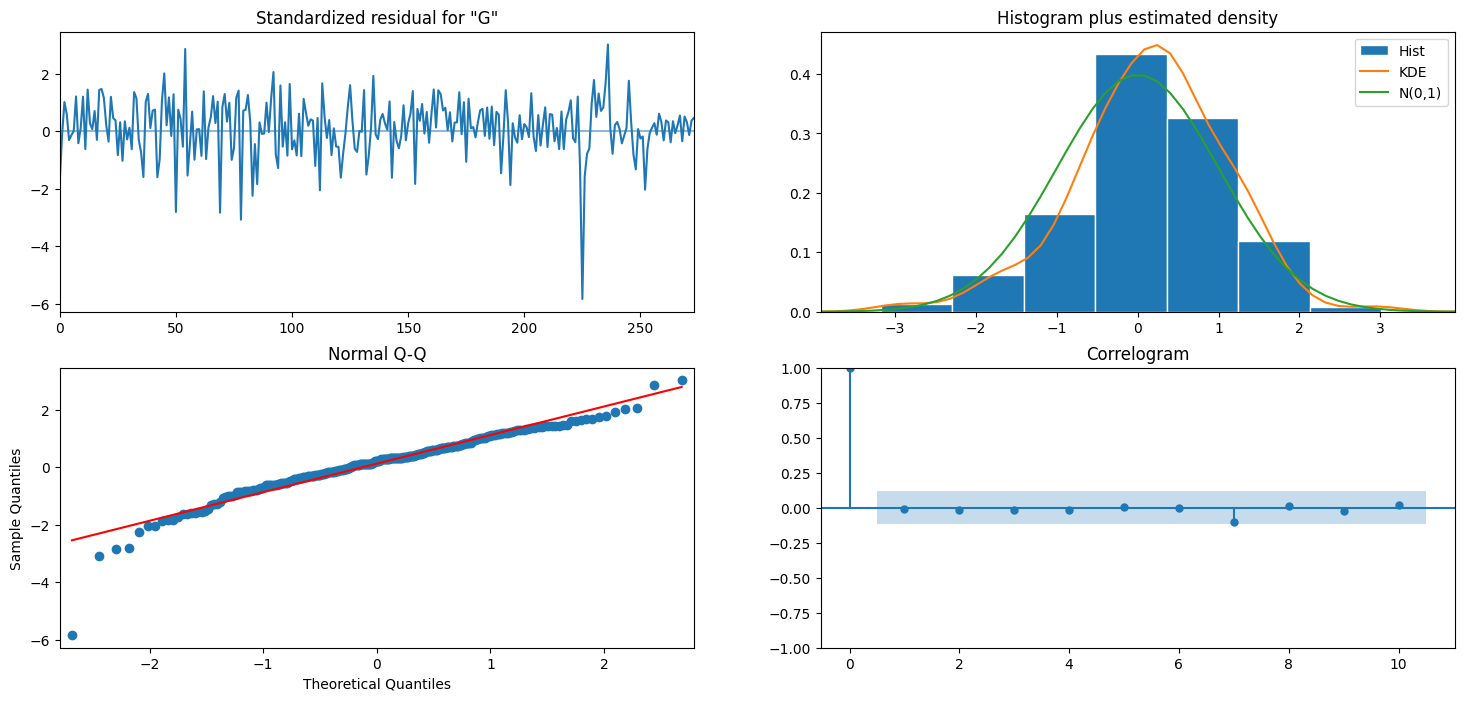

In [27]:
resultado_m511.plot_diagnostics(figsize=(18, 8))
plt.show()

In [28]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 111=",resultado_m111.aic)
print("Modelo 211=",resultado_m211.aic)
print("Modelo 212=",resultado_m212.aic)
print("Modelo 311=",resultado_m311.aic)
print("Modelo 411=",resultado_m411.aic)
print("Modelo 511=",resultado_m511.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 111=",resultado_m111.bic)
print("Modelo 211=",resultado_m211.bic)
print("Modelo 212=",resultado_m212.bic)
print("Modelo 311=",resultado_m311.aic)
print("Modelo 411=",resultado_m411.aic)
print("Modelo 511=",resultado_m511.aic)

Resultados de AIC (Akaike information criterion)
Modelo 111= -3.8758574563834127
Modelo 211= -9.868416186489721
Modelo 311= -6.955912563020739
Modelo 411= -4.286920830103199
Modelo 511= -1.405450270499598
Resultados de BIC (Bayesian information criterion)
Modelo 111= 6.996195062178602
Modelo 211= 4.627653838259633
Modelo 311= -6.955912563020739
Modelo 411= -4.286920830103199
Modelo 511= -1.405450270499598
